# Aplicando SVM para classificação de rostos

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Importando o dataset

In [2]:
from sklearn.datasets import fetch_olivetti_faces

In [3]:
faces = fetch_olivetti_faces(data_home='~/data/', shuffle=True, random_state=42)

### Particionando

In [4]:
from sklearn.model_selection import train_test_split
ts = 0.3
X_train, X_test, y_train, y_test = train_test_split(faces.images, 
                                                    faces.target, 
                                                    test_size=ts, 
                                                    stratify=faces.target,
                                                    random_state=42)

In [5]:
X_train.shape, y_train.shape

((280, 64, 64), (280,))

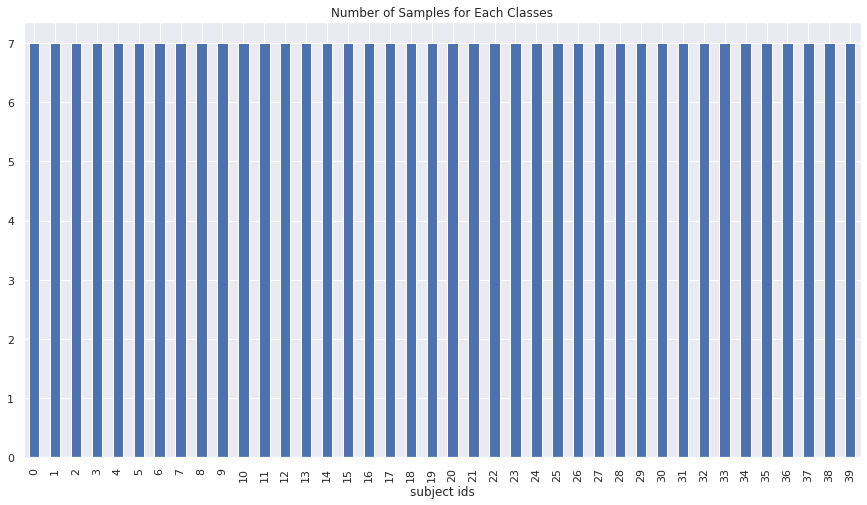

In [6]:
y_frame=pd.DataFrame()
y_frame['subject ids']=y_train
y_frame.groupby(['subject ids']).size().plot.bar(figsize=(15,8),title="Number of Samples for Each Classes")
plt.show()

### 40 rostos distintos

In [8]:
def show_40_distinct_people(images, unique_ids):
    #Creating 4X10 subplots in  18x9 figure size
    fig, axarr=plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    #For easy iteration flattened 4X10 subplots matrix to 40 array
    axarr=axarr.flatten()
    
    #iterating over user ids
    for unique_id in unique_ids:
        image_index=unique_id*10
        axarr[unique_id].imshow(images[image_index], cmap='bone')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
    plt.suptitle("There are 40 distinct people in the dataset")

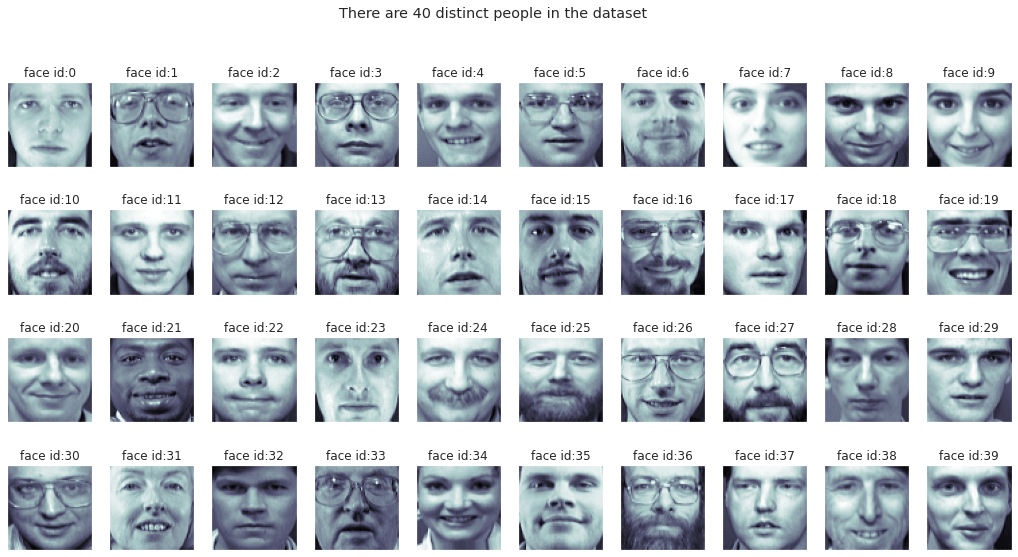

In [9]:
images, target = fetch_olivetti_faces(data_home='~/data/', return_X_y=True, shuffle=False, random_state=42)

images = images.reshape((images.shape[0], faces.images.shape[1], faces.images.shape[2]))

show_40_distinct_people(images, np.unique(target))

## Procurando um número ótimo de compontentes

In [10]:
from sklearn.decomposition import PCA

In [11]:
X = faces.images.reshape((faces.images.shape[0], faces.images.shape[1]*faces.images.shape[2]))
X.shape

(400, 4096)

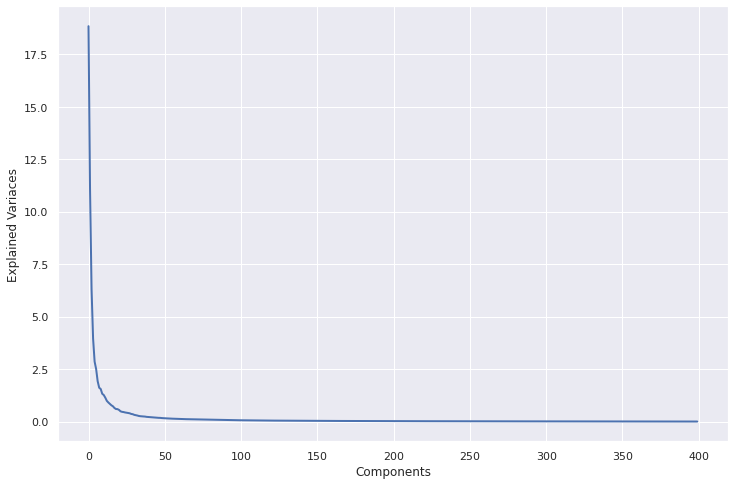

In [12]:
pca=PCA()
pca.fit(X)

plt.figure(1, figsize=(12,8))

plt.plot(pca.explained_variance_, linewidth=2)
 
plt.xlabel('Components')
plt.ylabel('Explained Variaces')
plt.show()

In [13]:
num_comp = 90

## Ajuste dos hiperparâmetros: GridSearchCV

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

In [15]:
pca = PCA(n_components=num_comp, whiten=True, random_state=42, svd_solver='auto')
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [16]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_train.shape

(280, 4096)

In [17]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
X_test.shape

(120, 4096)

In [18]:
param_grid = {
    'svc__C': [0.01, 0.5, 1, 5, 10, 50],
    'svc__kernel': ['poly', 'rbf', 'sigmoid'],
    'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05],
    'svc__decision_function_shape':  ['ovo', 'ovr']
}
grid = GridSearchCV(model, param_grid)

%time grid.fit(X_train, y_train)
print(grid.best_params_)

CPU times: user 4min 28s, sys: 3.12 s, total: 4min 31s
Wall time: 45.2 s
{'svc__C': 1, 'svc__decision_function_shape': 'ovo', 'svc__gamma': 0.01, 'svc__kernel': 'sigmoid'}


In [19]:
model = grid.best_estimator_
y_fit = model.predict(X_test)

In [20]:
model

Pipeline(steps=[('pca', PCA(n_components=90, random_state=42, whiten=True)),
                ('svc',
                 SVC(C=1, class_weight='balanced',
                     decision_function_shape='ovo', gamma=0.01,
                     kernel='sigmoid'))])

## Avaliando o modelo

### Imagens e rótulos

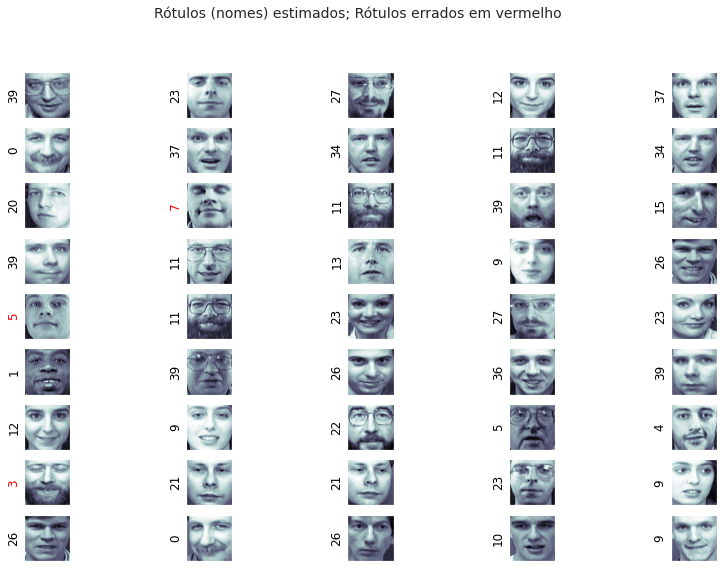

In [21]:
fig, ax = plt.subplots(9, 5, figsize=(14, 9))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(faces.images.shape[1], faces.images.shape[2]),
               cmap='bone')
    axi.set(xticks=[], 
            yticks=[])
    axi.set_ylabel(faces.target[y_fit[i]],
                   color='black' if y_fit[i] == y_test[i] else 'red')
fig.suptitle('Rótulos (nomes) estimados; Rótulos errados em vermelho', size=14);

### Relatório da classificação

In [22]:
from sklearn.metrics import classification_report

In [23]:
print(classification_report(y_test, y_fit))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      1.00      1.00         3
           2       0.67      0.67      0.67         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       0.75      1.00      0.86         3
           6       1.00      0.67      0.80         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       0.50      0.67      0.57         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       0.75      1.00      0.86         3
          16       1.00      1.00      1.00         3
          17       1.00    

### Matriz de confusão

In [24]:
from sklearn.metrics import confusion_matrix

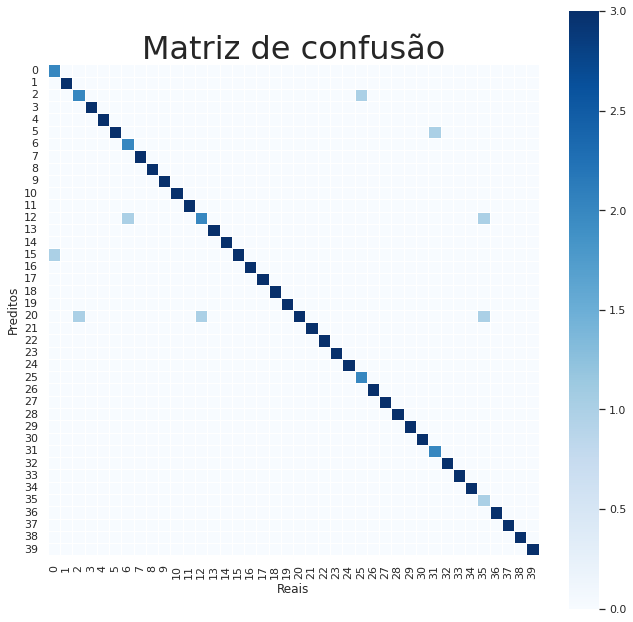

In [25]:
cm = confusion_matrix(y_test, y_fit, labels=range(40))
# cm = confusion_matrix(y_test, y_fit)

# list_labels = model.classes_.tolist()

plt.figure(figsize=(11, 11))
sns.heatmap(cm.T, 
            square=True, 
            cbar=True,
            linewidths=.9,
#             yticklabels=list_labels,
#             xticklabels=list_labels,
            cmap=plt.cm.Blues)

plt.title('Matriz de confusão',
          fontdict={'fontsize':32})
plt.xlabel('Reais')
plt.ylabel('Preditos')
# plt.xticks(rotation=0) 

plt.show()